In [91]:
from scipy.ndimage.filters import gaussian_laplace, convolve, rank_filter, generic_filter
from scipy.ndimage import gaussian_filter
import scipy.signal
from skimage.transform import resize, rescale
from skimage import color
from matplotlib.pyplot import imread
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import itertools
from time import time
from random import randint
import os

%matplotlib inline

In [7]:
def print_time(f):
    def new_f(*a, **b):
        t = time()
        res = f(*a, **b)
        print('{} : {}s elapsed.'.format(f.__name__, time()-t))
        return res
    return new_f

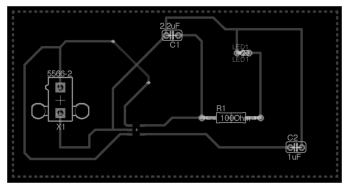

In [9]:
def get_gray_norm_image(path):
    orig_img = imread(path)
    gray_img = color.rgb2gray(orig_img)
    norm_img = gray_img/255.
    return norm_img

img = get_gray_norm_image('./pcb_image_1.png')
plt.axis('off')
plt.imshow(img, cmap='gray')

In [10]:
def construct_sigmas(num_levels, initial, k):
    sigmas = [initial]
    for i in range(num_levels-1):
        sigmas.append(sigmas[-1]*k)
    return sigmas

In [11]:
@print_time
def get_laplacian_scale_space_naive(img, sigmas):
    num_levels = len(sigmas)
    h, w = img.shape
    res = np.zeros((h, w, num_levels))
    
    for i in range(num_levels):
        filter_size = int(6*sigmas[i])
        filter_size += 1-(filter_size%2)
        gauss_filter = np.zeros((filter_size, filter_size))
        gauss_filter[filter_size//2][filter_size//2] = 1
        
        Lap_of_gau = (sigmas[i]**2)*gaussian_laplace(gauss_filter, sigmas[i]) 
        res[:, :, i] = convolve(img, Lap_of_gau)**2
    
    return res

get_laplacian_scale_space_naive : 14.620930433273315s elapsed.


In [12]:
def non_maximum_suppression_2D(lap_scale_space):
    h, w, num_levels = lap_scale_space.shape
    local_max = np.zeros(lap_scale_space.shape)
    for i in range(num_levels):
        response = lap_scale_space[:, :, i]
        local_max[:, :, i] = rank_filter(response, -1, (3, 3))
    return local_max

@print_time
def non_maximum_suppression_3D(lap_scale_space):
    local_max = non_maximum_suppression_2D(lap_scale_space)
    h, w, num_levels = lap_scale_space.shape
    global_max = np.zeros(local_max.shape)
    
    for i in range(h):
        for j in range(w):
            max_idx = np.argmax(local_max[i, j, :])
            global_max[i, j, max_idx] = local_max[i, j, max_idx]
    
    for i in range(num_levels):
        global_max[:, :, i] = np.where((global_max[:, :, i]==lap_scale_space[:, :, i]), global_max[:, :, i], 0)
    return global_max

non_maximum_suppression_3D : 0.6403169631958008s elapsed.


In [13]:
@print_time
def post_process(global_max, sigmas, threshold=1e-7):
    '''
    Set lower bound for global max
    Remove boundary noise
    '''
    h, w, num_levels = global_max.shape
    masks = np.zeros(global_max.shape)
    for i in range(num_levels):
        b = int(np.ceil(sigmas[i]*np.sqrt(2))) # boundary size
        masks[b+1:h-b, b+1:w-b, i] = 1
        
    for i in range(num_levels):
        global_max[:, :, i] = np.where((global_max[:, :, i] > threshold) & (masks[:, :, i] == 1), 1, 0)

post_process : 0.09175443649291992s elapsed.


In [14]:
@print_time
def blob_detection(sigmas, global_max):
    h, w, num_levels  = global_max.shape
    
    row_idx, col_idx, radius = [], [], []
    for i in range(num_levels):
        local_max_idx = np.where(global_max[:, :, i]==1)
        row_idx.append(list(local_max_idx[0]))
        col_idx.append(list(local_max_idx[1]))
        radius.append(list(np.ones(len(row_idx[i])) * np.sqrt(2) * sigmas[i]))
        
    flatten_list = lambda x : list(itertools.chain.from_iterable(x))
    row_idx = flatten_list(row_idx)
    col_idx = flatten_list(col_idx)
    radius =  flatten_list(radius)
    return row_idx, col_idx, radius

blob_detection : 0.027925729751586914s elapsed.


In [92]:
def show_all_circles(image, cx, cy, rad, color='r', output_file='output.png'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=True)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.axis('on')
    plt.savefig(output_file)
    plt.show()

In [55]:
# part (b), improvement
@print_time
def get_laplacian_scale_space_downsample(img, sigmas):
    k = sigmas[1]/sigmas[0]
    num_levels = len(sigmas)
    h, w = img.shape
    res = np.zeros((h, w, num_levels))
    
    filter_size = int(6*sigmas[0])
    filter_size += 1-(filter_size%2)
    gauss_filter = np.zeros((filter_size, filter_size))
    gauss_filter[filter_size//2][filter_size//2] = 1

    Lap_of_gau = gaussian_laplace(gauss_filter, sigmas[0])
    for i in range(num_levels):
        scaled_h = int(h/k**i)
        scaled_w = int(w/k**i)
        scaled_img = rescale(img, 1/k**i, order=3)
        
        res_downsampled = convolve(scaled_img, Lap_of_gau)**2
        res[:, :, i] = resize(res_downsampled, (h, w), order=3)
    
    return res

In [93]:
@print_time
def main(path_to_img, downsample=True, threshold = 3e-8, output_file='output.png'):
    img = get_gray_norm_image(path_to_img)
    sigmas = construct_sigmas(11, 2, 1.25)
    get_laplacian_response = get_laplacian_scale_space_naive if not downsample else get_laplacian_scale_space_downsample
    
    lap_scale_space = get_laplacian_response(img, sigmas)
    
    global_max = non_maximum_suppression_3D(lap_scale_space)
    post_process(global_max, sigmas, threshold)
    
    row_idx, col_idx, radius = blob_detection(sigmas, global_max)
    show_all_circles(img, col_idx, row_idx, radius, output_file=output_file)

get_laplacian_scale_space_downsample : 0.8085718154907227s elapsed.
non_maximum_suppression_3D : 0.7100121974945068s elapsed.
post_process : 0.09466314315795898s elapsed.
blob_detection : 0.03077244758605957s elapsed.


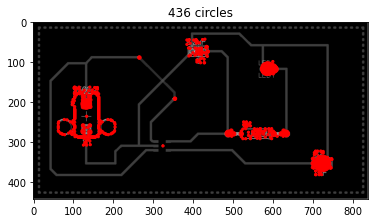

main : 2.267143487930298s elapsed.


In [94]:
main('./pcb_image_1.png', output_file='output_1.png')

get_laplacian_scale_space_downsample : 0.813643217086792s elapsed.
non_maximum_suppression_3D : 0.7049980163574219s elapsed.
post_process : 0.09415555000305176s elapsed.
blob_detection : 0.023932218551635742s elapsed.


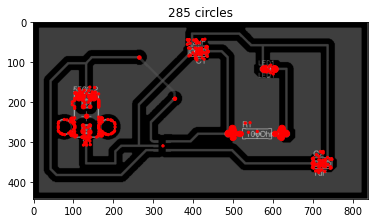

main : 2.1417505741119385s elapsed.


In [95]:
main('./pcb_image_2.png', output_file='output_2.png')

In [82]:
@print_time
def detect_boxes(img):
    m, n, _ = img.shape
    num_red = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            num_red[i][j] = num_red[i-1][j]+num_red[i][j-1]-num_red[i-1][j-1]+(img[i, j, 0] > 128)
    
    num_red_in_range = lambda si, sj, ei, ej : num_red[ei][ej]+num_red[si][sj]-num_red[ei][sj]-num_red[si][ej]
    num_red_ratio = lambda si, sj, ei, ej : num_red_in_range(si, sj, ei, ej)/(ej-sj+1)/(ei-si+1)
    
    big_thing_size = (175, 125)
    big_thing_location 

(288, 432, 4)
(442, 838, 4)
